# Andmete ettevalmistus RAG süsteemi jaoks

See vihik viib läbi ÕIS2 aineandmete ettevalmistuse, et need oleksid valmis filtreerimiseks ja RAG (Retrieval-Augmented Generation) süsteemis kasutamiseks.

**Sisend:** `../andmed/toorandmed_aasta.csv`  
**Väljund:** `../andmed/puhastatud_ained.csv`

### Peamised sammud:
1. **Eelfiltrid** – eemaldame ained, mida me ei vaja (kestus > 1 semester, kaitsmise ained)
2. **Veergude valik ja ühendamine** – eelistame `version__` prefiksiga veerge, puudumisel kasutame üldist infot
3. **JSON väljade parsimine** – teisendame JSON-struktuurid inimloetavaks tekstiks
4. **Kategooriliste tunnuste puhastamine** – kontrollime filtreerimiseks vajalike veergude väärtused
5. **Kirjelduse koostamine** – ühendame kogu aine info üheks RAG-sõbralikuks tekstiväljaks
6. **Valideerimine ja salvestamine** – puuduvad väärtused, kategoorilised jaotused, näidisaine

## Samm 0: Teekide laadimine ja andmete sisselugemine

In [1]:
import pandas as pd
import json
import numpy as np
import os
import textwrap

# Pandase kuvaseaded
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 120)
pd.set_option('display.max_rows', 100)

# Failipead
INPUT_FILE = '../andmed/toorandmed_aasta.csv'
OUTPUT_FILE = '../andmed/puhastatud_ained.csv'

# Loeme andmed sisse
if not os.path.exists(INPUT_FILE):
    raise FileNotFoundError(f"Sisendfaili '{INPUT_FILE}' ei leitud!")

df_raw = pd.read_csv(INPUT_FILE, low_memory=False)
print(f"Toorandmed sisse loetud: {df_raw.shape[0]} rida, {df_raw.shape[1]} veergu.")

Toorandmed sisse loetud: 3416 rida, 229 veergu.


## Samm 1: Eelfiltrid

Eemaldame andmestikust ained, mida me RAG süsteemis ei vaja:

1. **Päevaõpe** – andmestikus on juba ainult päevaõppe ained (kontrollime seda)
2. **Kestus > 1 semester** – eemaldame ained, mille kestus on rohkem kui 1 semester
3. **Kaitsmise ained** – eemaldame ained, mille tüüp on "Kaitsmisega lõppev aine"

In [2]:
df = df_raw.copy()
algne_arv = len(df)

# 1. Kontrollime, et andmestikus on ainult päevaõpe
print("=== Õppetüübi kontroll ===")
print(df['version__target__study_type__et'].value_counts(dropna=False))
print()

# 2. Eemaldame ained, mille kestus on rohkem kui 1 semester
mask_kestus = df['additional_info__duration_in_semesters'] > 1
print(f"Kestus > 1 semester: {mask_kestus.sum()} ainet eemaldatakse")
df = df[~mask_kestus]

# 3. Eemaldame kaitsmise ained
mask_kaitsmine = df['general__type__et'] == 'Kaitsmisega lõppev aine'
print(f"Kaitsmisega lõppevad ained: {mask_kaitsmine.sum()} ainet eemaldatakse")
df = df[~mask_kaitsmine]

print(f"\nEelfiltrite tulemus: {algne_arv} → {len(df)} ainet ({algne_arv - len(df)} eemaldatud)")
df = df.reset_index(drop=True)

=== Õppetüübi kontroll ===
version__target__study_type__et
päevaõpe    3399
NaN           17
Name: count, dtype: int64

Kestus > 1 semester: 459 ainet eemaldatakse
Kaitsmisega lõppevad ained: 53 ainet eemaldatakse

Eelfiltrite tulemus: 3416 → 2904 ainet (512 eemaldatud)


## Samm 2: Veergude valik ja version/general info ühendamine

Valime välja vajalikud veerud ja ühendame need. Eelistame alati `version__` prefiksiga veerge (aine konkreetse versiooni info), puudumisel kasutame üldist infot.

**Hard-filtrite veerud** (ridade eelfiltreerimiseks enne RAG-otsingut):
- `eristav_mitteeristav` – hindamisskaala (eristav / mitteeristav)
- `semester` – kevad / sügis
- `oppeaste` – bakalaureuseõpe, magistriõpe jne
- `keel` – eesti keel / inglise keel
- `asukoht` – linn (Tartu)

**Kirjeldusse lisatav info** (RAG-otsinguks):
- Aine kirjeldus, eesmärgid, õpiväljundid, eeldusained, hindamisinfo, õppejõud jm

In [3]:
def resolve_fields(df):
    """
    Loob uued puhtad veerud, eelistades versiooni-põhist infot.
    
    merge_mapping: (uus_nimi, üldise_info_veerg, versiooni_veerg)
        → väärtus tuleb version-veerust, puudumisel üldisest veerust
    rename_mapping: (uus_nimi, lähteveerg)
        → lihtne ümbernimetamine
    """

    # Veerud, kus eelistame version-infot, puudumisel kasutame üldist
    merge_mapping = [
        # Põhiinfo
        ('nimi_et',       'title__et',                           'version__title__et'),
        ('nimi_en',       'title__en',                           'version__title__en'),
        ('eap',           'credits',                             'version__credits'),
        
        # Kirjeldus ja sisu
        ('kirjeldus_et',  'overview__description__et',           'version__overview__description__et'),
        ('kirjeldus_en',  'overview__description__en',           'version__overview__description__en'),
        ('eesmark_json',  'overview__objectives',                'version__overview__objectives'),
        ('opivaljundid_json', 'overview__learning_outcomes',     'version__overview__learning_outcomes'),
        
        # Õpiväljundid ja eesmärgid tekstina (plain text versioonid)
        ('eesmark_tekst_et',     'overview__objectives_text_et',          'version__overview__objectives_text_et'),
        ('opivaljundid_tekst_et','overview__learning_outcomes_text_et',   'version__overview__learning_outcomes_text_et'),
        
        # Hindamisskaala
        ('hindamisskaala', 'additional_info__assessment_scale__et', 'version__grading__assessment_scale__et'),
    ]

    # Veerud, mis tulevad ühest konkreetsest kohast
    rename_mapping = [
        ('aine_kood',        'code'),
        ('semester',         'version__target__semester__et'),
        ('keel',             'version__target__language__et'),
        ('asukoht',          'version__target__faculty__city'),
        ('oppeaste_json',    'version__additional_info__study_levels'),
        ('aine_tyyp',        'general__type__et'),
        ('eeldusained_json', 'additional_info__prerequisites'),
        ('oppejoud_json',    'version__participants__lecturers'),
        ('toimumisajad_json','version__schedule__entries'),
        ('teaduskond_et',    'version__target__faculty__name__et'),
        ('struktuuriyksus_et','version__target__course_main_structural_unit__name__et'),
        
        # Hindamisinfo
        ('hindamise_eeltingimused',  'version__grading__grade_preconditions__et'),
        ('hindamismeetod',           'version__grading__grade_evaluation__et'),
        ('volgnevus_kord',           'version__grading__debt_elimination__et'),
        ('iseseisev_too',            'version__grading__independent_work__et'),
        
        # Ainemaht
        ('tunnid_loeng',      'version__additional_info__hours__lecture'),
        ('tunnid_praktikum',  'version__additional_info__hours__practice'),
        ('tunnid_seminar',    'version__additional_info__hours__seminar'),
        ('tunnid_iseseisev',  'version__additional_info__hours__independent_work'),
        ('tunnid_e_ope',      'version__additional_info__hours__web_learning'),
    ]

    print("Alustan veergude filtreerimist ja ühendamist...")
    
    # Version/general merge
    for new_col, base, version in merge_mapping:
        base_exists = base in df.columns
        ver_exists = version in df.columns
        if base_exists and ver_exists:
            df[new_col] = df[version].fillna(df[base])
        elif ver_exists:
            df[new_col] = df[version]
        elif base_exists:
            df[new_col] = df[base]
        else:
            df[new_col] = np.nan
    
    # Ümbernimetamine
    for new_col, source in rename_mapping:
        if source in df.columns:
            df[new_col] = df[source]
        else:
            df[new_col] = np.nan
            print(f"  Hoiatus: veergu '{source}' ei leitud")
    
    return df


df = resolve_fields(df)
print("Veergude valik ja ühendamine tehtud.")

Alustan veergude filtreerimist ja ühendamist...
Veergude valik ja ühendamine tehtud.


## Samm 3: JSON väljade parsimine

Mitmed veerud sisaldavad andmeid JSON-formaadis stringidena. Teisendame need inimloetavaks tekstiks:

- **Õppeaste** (`oppeaste_json`) → komadega eraldatud loetelu (nt "bakalaureuseõpe, magistriõpe")
- **Eeldusained** (`eeldusained_json`) → ainekoodid ja nimetused
- **Õpiväljundid** (`opivaljundid_json`) → eestikeelne tekst
- **Eesmärgid** (`eesmark_json`) → eestikeelne tekst
- **Õppejõud** (`oppejoud_json`) → nimed
- **Toimumisajad** (`toimumisajad_json`) → nädalapäevad

In [4]:
# --- Abifunktsioonid JSON töötlemiseks ---

def parse_json_safe(json_str):
    """Teisendab JSON-stringi turvaliselt Pythoni objektiks."""
    if pd.isna(json_str) or json_str == '':
        return None
    try:
        return json.loads(json_str)
    except (json.JSONDecodeError, TypeError):
        return None


def extract_study_levels(json_str):
    """Eraldab õppeastmed JSON-struktuurist, tagastab komadega eraldatud ET-nimed."""
    data = parse_json_safe(json_str)
    if not data:
        return None
    levels = [item.get('et', item.get('code', '')) for item in data if isinstance(item, dict)]
    return ", ".join(levels) if levels else None


def extract_prerequisites(json_str):
    """Eraldab eeldusainete koodid ja nimetused."""
    data = parse_json_safe(json_str)
    if not data:
        return None
    parts = []
    for item in data:
        if not isinstance(item, dict):
            continue
        code = item.get('code', '')
        title_et = item.get('title', {}).get('et', '') if isinstance(item.get('title'), dict) else ''
        if code and title_et:
            parts.append(f"{code} {title_et}")
        elif code:
            parts.append(code)
    return "; ".join(parts) if parts else None


def extract_json_text_et(json_str):
    """Eraldab JSON-listist eestikeelse teksti (objectives, learning_outcomes)."""
    data = parse_json_safe(json_str)
    if not data:
        return None
    texts = []
    for item in data:
        if isinstance(item, dict):
            et_text = item.get('et', '')
            if et_text:
                texts.append(et_text.strip())
        elif isinstance(item, str):
            texts.append(item.strip())
    return "\n".join(texts) if texts else None


def extract_lecturers(json_str):
    """Eraldab õppejõudude nimed, tagastab unikaalsed nimed tähestikuliselt."""
    data = parse_json_safe(json_str)
    if not data:
        return None
    names = [p.get('person_name') for p in data if isinstance(p, dict) and p.get('person_name')]
    return ", ".join(sorted(set(names))) if names else None


def extract_schedule_days(json_str):
    """Eraldab tunniplaanist nädalapäevad eesti keeles."""
    data = parse_json_safe(json_str)
    if not data:
        return None
    days = set()
    day_map = {
        'Monday': 'Esmaspäev', 'Tuesday': 'Teisipäev', 'Wednesday': 'Kolmapäev',
        'Thursday': 'Neljapäev', 'Friday': 'Reede', 'Saturday': 'Laupäev', 'Sunday': 'Pühapäev'
    }
    for entry in data:
        if not isinstance(entry, dict):
            continue
        time_str = entry.get('time') or entry.get('start_time')
        if time_str:
            dt = pd.to_datetime(time_str, errors='coerce')
            if not pd.isna(dt):
                days.add(day_map.get(dt.day_name(), dt.day_name()))
    week_order = ['Esmaspäev', 'Teisipäev', 'Kolmapäev', 'Neljapäev', 'Reede', 'Laupäev', 'Pühapäev']
    sorted_days = sorted(days, key=lambda d: week_order.index(d) if d in week_order else 99)
    return ", ".join(sorted_days) if sorted_days else None


# --- Rakendame JSON parsimise ---
print("Parsime JSON välju...")

df['oppeaste'] = df['oppeaste_json'].apply(extract_study_levels)
df['eeldusained'] = df['eeldusained_json'].apply(extract_prerequisites)
df['opivaljundid'] = df['opivaljundid_json'].apply(extract_json_text_et)
df['eesmark'] = df['eesmark_json'].apply(extract_json_text_et)
df['oppejoud'] = df['oppejoud_json'].apply(extract_lecturers)
df['toimumispaevad'] = df['toimumisajad_json'].apply(extract_schedule_days)

# Kasutame ka plain text versioone kui JSON parsimine ei andnud tulemust
df['opivaljundid'] = df['opivaljundid'].fillna(df['opivaljundid_tekst_et'])
df['eesmark'] = df['eesmark'].fillna(df['eesmark_tekst_et'])

print("JSON parsimine tehtud.")
print(f"\nNäide – õppejõud: {df['oppejoud'].dropna().iloc[0]}")
print(f"Näide – õppeaste: {df['oppeaste'].dropna().iloc[0]}")
print(f"Näide – eeldusained: {df['eeldusained'].dropna().iloc[0]}")

Parsime JSON välju...
JSON parsimine tehtud.

Näide – õppejõud: Gea Lepik
Näide – õppeaste: magistriõpe
Näide – eeldusained: AR00.00.016 Diagnostika alused


## Samm 4: Kategooriliste tunnuste puhastamine ja hard-filtrite loomine

Loome filtreerimiseks vajalikud puhtad kategoorilised veerud:
- **`eristav_mitteeristav`** – lihtsustatud hindamisskaala ("eristav" / "mitteeristav")
- **`semester`** – "kevad" / "sügis"
- **`oppeaste`** – õppeastmete komadega loetelu
- **`keel`** – aine keel
- **`asukoht`** – linn
- **`on_eksam`** – kas hindamismeetodist selgub, et toimub eksam

In [5]:
# --- Eristav / mitteeristav ---
def classify_assessment(val):
    """Lihtsustab hindamisskaala 'eristav' / 'mitteeristav' kategooriaks."""
    if pd.isna(val):
        return None
    val_lower = val.lower()
    if 'eristav' in val_lower and 'eristamata' not in val_lower:
        return 'eristav'
    elif 'eristamata' in val_lower or 'arv' in val_lower:
        return 'mitteeristav'
    return None

df['eristav_mitteeristav'] = df['hindamisskaala'].apply(classify_assessment)

# --- Eksami tuvastamine hindamismeetodist ---
def detect_exam(row):
    """Kontrollib hindamismeetodist ja eeltingimustest, kas on mainitud eksamit."""
    texts = [
        str(row.get('hindamismeetod', '')),
        str(row.get('hindamise_eeltingimused', ''))
    ]
    combined = ' '.join(texts).lower()
    exam_keywords = ['eksam', 'exam', 'kirjalik eksam', 'suuline eksam']
    return any(kw in combined for kw in exam_keywords)

df['on_eksam'] = df.apply(detect_exam, axis=1)

# --- Semester puhastamine ---
df['semester'] = df['semester'].str.strip().str.lower()

# --- Keel puhastamine ---
df['keel'] = df['keel'].str.strip().str.lower()

# --- Asukoht puhastamine (ühtlustame nimetust) ---
df['asukoht'] = df['asukoht'].str.strip().replace({
    'Tartu linn': 'Tartu',
    'Tartu': 'Tartu',
})

# Kontrollime tulemusi
print("=== Puhastatud kategoorilised tunnused ===\n")

for col_name in ['eristav_mitteeristav', 'semester', 'keel', 'asukoht', 'on_eksam']:
    print(f"--- {col_name} ---")
    print(df[col_name].value_counts(dropna=False))
    print()

print(f"--- oppeaste (top 5) ---")
print(df['oppeaste'].value_counts(dropna=False).head(5))

=== Puhastatud kategoorilised tunnused ===

--- eristav_mitteeristav ---
eristav_mitteeristav
eristav         1685
mitteeristav    1219
Name: count, dtype: int64

--- semester ---
semester
kevad    1528
sügis    1362
NaN        14
Name: count, dtype: int64

--- keel ---
keel
eesti keel      2134
inglise keel     756
NaN               14
Name: count, dtype: int64

--- asukoht ---
asukoht
Tartu    2890
NaN        14
Name: count, dtype: int64

--- on_eksam ---
on_eksam
False    1853
True     1051
Name: count, dtype: int64

--- oppeaste (top 5) ---
oppeaste
bakalaureuseõpe                               905
magistriõpe                                   535
bakalaureuseõpe, magistriõpe                  306
integreeritud bakalaureuse- ja magistriõpe    239
bakalaureuseõpe, magistriõpe, doktoriõpe      190
Name: count, dtype: int64


## Samm 5: Lõpliku andmestiku koostamine ja RAG-kirjelduse loomine

Loome kaks olulist asja:
1. **Lõplik veergude valik** – jätame alles ainult vajalikud veerud
2. **`kirjeldus`** – ühe aine kogu info ühendatuna üheks suureks tekstiväljaks, mida RAG süsteem saab kasutada

In [6]:
# --- Lõplikud veerud ---
final_cols = [
    # Identifikaatorid
    'aine_kood', 'nimi_et', 'nimi_en', 'eap',
    
    # Hard-filtrite veerud
    'semester', 'eristav_mitteeristav', 'oppeaste', 'keel', 'asukoht', 'on_eksam',
    
    # Kirjeldusse lisatav info
    'kirjeldus_et', 'kirjeldus_en', 'eesmark', 'opivaljundid', 'eeldusained',
    'hindamise_eeltingimused', 'hindamismeetod', 'volgnevus_kord', 'iseseisev_too',
    
    # Metainfo
    'aine_tyyp', 'teaduskond_et', 'struktuuriyksus_et', 'oppejoud', 'toimumispaevad',
    'tunnid_loeng', 'tunnid_praktikum', 'tunnid_seminar', 'tunnid_iseseisev', 'tunnid_e_ope',
]

# Kontrollime, et kõik veerud olemas
missing_cols = [c for c in final_cols if c not in df.columns]
if missing_cols:
    print(f"Hoiatus: puuduvad veerud: {missing_cols}")

existing_cols = [c for c in final_cols if c in df.columns]
df_final = df[existing_cols].copy()

print(f"Lõplik andmestik: {df_final.shape[0]} rida, {df_final.shape[1]} veergu")
print(f"Veerud: {list(df_final.columns)}")

Lõplik andmestik: 2904 rida, 29 veergu
Veerud: ['aine_kood', 'nimi_et', 'nimi_en', 'eap', 'semester', 'eristav_mitteeristav', 'oppeaste', 'keel', 'asukoht', 'on_eksam', 'kirjeldus_et', 'kirjeldus_en', 'eesmark', 'opivaljundid', 'eeldusained', 'hindamise_eeltingimused', 'hindamismeetod', 'volgnevus_kord', 'iseseisev_too', 'aine_tyyp', 'teaduskond_et', 'struktuuriyksus_et', 'oppejoud', 'toimumispaevad', 'tunnid_loeng', 'tunnid_praktikum', 'tunnid_seminar', 'tunnid_iseseisev', 'tunnid_e_ope']


In [7]:
def build_rag_description(row):
    """
    Koostab ühe aine kohta kogu info üheks tekstiks, mida RAG süsteem saab kasutada.
    Sisaldab kõikide veergude sisu struktureeritud kujul.
    """
    parts = []
    
    # Põhiinfo
    parts.append(f"Aine: {row.get('nimi_et', 'N/A')} ({row.get('aine_kood', 'N/A')})")
    if pd.notna(row.get('nimi_en')):
        parts.append(f"Ingliskeelne nimetus: {row['nimi_en']}")
    parts.append(f"Maht: {row.get('eap', 'N/A')} EAP")
    
    # Metainfo
    meta_parts = []
    if pd.notna(row.get('semester')):
        meta_parts.append(f"Semester: {row['semester']}")
    if pd.notna(row.get('keel')):
        meta_parts.append(f"Keel: {row['keel']}")
    if pd.notna(row.get('eristav_mitteeristav')):
        meta_parts.append(f"Hindamine: {row['eristav_mitteeristav']}")
    if pd.notna(row.get('oppeaste')):
        meta_parts.append(f"Õppeaste: {row['oppeaste']}")
    if pd.notna(row.get('teaduskond_et')):
        meta_parts.append(f"Teaduskond: {row['teaduskond_et']}")
    if pd.notna(row.get('struktuuriyksus_et')):
        meta_parts.append(f"Struktuuriüksus: {row['struktuuriyksus_et']}")
    if pd.notna(row.get('oppejoud')):
        meta_parts.append(f"Õppejõud: {row['oppejoud']}")
    if pd.notna(row.get('toimumispaevad')):
        meta_parts.append(f"Toimumispäevad: {row['toimumispaevad']}")
    if row.get('on_eksam'):
        meta_parts.append("Eksam: jah")
    if meta_parts:
        parts.append(" | ".join(meta_parts))
    
    # Tunnid
    tunnid = []
    for label, col in [('Loeng', 'tunnid_loeng'), ('Praktikum', 'tunnid_praktikum'),
                         ('Seminar', 'tunnid_seminar'), ('Iseseisev töö', 'tunnid_iseseisev'),
                         ('E-õpe', 'tunnid_e_ope')]:
        val = row.get(col)
        if pd.notna(val) and val > 0:
            tunnid.append(f"{label}: {int(val)}h")
    if tunnid:
        parts.append("Tundide jaotus: " + ", ".join(tunnid))
    
    # Kirjeldus
    if pd.notna(row.get('kirjeldus_et')):
        parts.append(f"\nAine kirjeldus:\n{row['kirjeldus_et']}")
    
    # Eesmärgid
    if pd.notna(row.get('eesmark')):
        parts.append(f"\nEesmärgid:\n{row['eesmark']}")
    
    # Õpiväljundid
    if pd.notna(row.get('opivaljundid')):
        parts.append(f"\nÕpiväljundid:\n{row['opivaljundid']}")
    
    # Eeldusained
    if pd.notna(row.get('eeldusained')):
        parts.append(f"\nEeldusained:\n{row['eeldusained']}")
    
    # Hindamisinfo
    hindamine_parts = []
    if pd.notna(row.get('hindamise_eeltingimused')):
        hindamine_parts.append(f"Eeltingimused: {row['hindamise_eeltingimused']}")
    if pd.notna(row.get('hindamismeetod')):
        hindamine_parts.append(f"Hindamismeetod: {row['hindamismeetod']}")
    if pd.notna(row.get('iseseisev_too')):
        hindamine_parts.append(f"Iseseisev töö: {row['iseseisev_too']}")
    if pd.notna(row.get('volgnevus_kord')):
        hindamine_parts.append(f"Võlgnevuse kõrvaldamine: {row['volgnevus_kord']}")
    if hindamine_parts:
        parts.append("\nHindamine:\n" + "\n".join(hindamine_parts))
    
    return "\n".join(parts)


# Loome kirjelduse veeru
df_final['kirjeldus'] = df_final.apply(build_rag_description, axis=1)

print("RAG-kirjeldus loodud.")
print(f"Kirjelduse keskmine pikkus: {df_final['kirjeldus'].str.len().mean():.0f} tähemärki")
print(f"\nNäide (esimesed 500 tähemärki):")
print(df_final['kirjeldus'].iloc[0][:500])

RAG-kirjeldus loodud.
Kirjelduse keskmine pikkus: 2339 tähemärki

Näide (esimesed 500 tähemärki):
Aine: Rahvusvaheline eraõigus (OIEO.06.046)
Ingliskeelne nimetus: Private International Law
Maht: 6.0 EAP
Semester: kevad | Keel: eesti keel | Hindamine: eristav | Õppeaste: magistriõpe | Teaduskond: sotsiaalteaduste valdkond | Struktuuriüksus: eraõiguse osakond | Õppejõud: Gea Lepik | Eksam: jah
Tundide jaotus: Loeng: 20h, Seminar: 24h, Iseseisev töö: 112h

Aine kirjeldus:
Kursuse raames käsitletakse rahvusvahelise eraõiguse põhiteemasid, terminoloogiat ja kujunemist, tutvustatakse ja õpetataks


## Samm 6: Salvestamine

In [8]:
# Salvestame puhastatud andmed
df_final.to_csv(OUTPUT_FILE, index=False)
print(f"Andmestik salvestatud: '{OUTPUT_FILE}'")
print(f"Lõplik suurus: {df_final.shape[0]} rida, {df_final.shape[1]} veergu")

Andmestik salvestatud: '../andmed/puhastatud_ained.csv'
Lõplik suurus: 2904 rida, 30 veergu


## Samm 7: Valideerimise väljundid

### 7.1 Puuduvate väärtuste hulk igas veerus

In [9]:
# 7.1 Puuduvate väärtuste hulk igas veerus
print("=" * 60)
print("PUUDUVAD VÄÄRTUSED IGAS VEERUS")
print("=" * 60)

missing = df_final.isnull().sum()
total = len(df_final)

missing_df = pd.DataFrame({
    'Veerg': missing.index,
    'Puuduvaid': missing.values,
    'Osakaal (%)': (missing.values / total * 100).round(1)
})
missing_df = missing_df.sort_values('Puuduvaid', ascending=False)
print(missing_df.to_string(index=False))

PUUDUVAD VÄÄRTUSED IGAS VEERUS
                  Veerg  Puuduvaid  Osakaal (%)
            eeldusained       2371         81.6
         toimumispaevad       1840         63.4
          iseseisev_too        967         33.3
           tunnid_e_ope        597         20.6
         volgnevus_kord        397         13.7
hindamise_eeltingimused        361         12.4
         hindamismeetod        347         11.9
               oppeaste         48          1.7
         tunnid_seminar         18          0.6
       tunnid_praktikum         18          0.6
           tunnid_loeng         15          0.5
               oppejoud         15          0.5
                   keel         14          0.5
               semester         14          0.5
       tunnid_iseseisev         14          0.5
     struktuuriyksus_et         14          0.5
                asukoht         14          0.5
          teaduskond_et         14          0.5
           opivaljundid          4          0.1
         

### 7.2 Kategooriliste tunnuste enim levinud väärtused

In [10]:
# 7.2 Kategooriliste tunnuste enim levinud väärtused
print("=" * 60)
print("KATEGOORILISTE TUNNUSTE LEVINUMAD VÄÄRTUSED (TOP 5)")
print("=" * 60)

categorical_cols = ['semester', 'eristav_mitteeristav', 'oppeaste', 'keel', 'asukoht', 'on_eksam', 'aine_tyyp']

for col in categorical_cols:
    if col in df_final.columns:
        print(f"\n--- {col} ---")
        print(df_final[col].value_counts(dropna=False).head(5))
        print()

KATEGOORILISTE TUNNUSTE LEVINUMAD VÄÄRTUSED (TOP 5)

--- semester ---
semester
kevad    1528
sügis    1362
NaN        14
Name: count, dtype: int64


--- eristav_mitteeristav ---
eristav_mitteeristav
eristav         1685
mitteeristav    1219
Name: count, dtype: int64


--- oppeaste ---
oppeaste
bakalaureuseõpe                               905
magistriõpe                                   535
bakalaureuseõpe, magistriõpe                  306
integreeritud bakalaureuse- ja magistriõpe    239
bakalaureuseõpe, magistriõpe, doktoriõpe      190
Name: count, dtype: int64


--- keel ---
keel
eesti keel      2134
inglise keel     756
NaN               14
Name: count, dtype: int64


--- asukoht ---
asukoht
Tartu    2890
NaN        14
Name: count, dtype: int64


--- on_eksam ---
on_eksam
False    1853
True     1051
Name: count, dtype: int64


--- aine_tyyp ---
aine_tyyp
Tavaline aine    2781
Praktika          119
Kompleksaine        4
Name: count, dtype: int64



### 7.3 "Sissejuhatus andmeteadusse" aine puhastatud kujul

Näitame ühe konkreetse aine kogu puhastatud infot kenasti vormistatud kujul.

In [11]:
# 7.3 "Sissejuhatus andmeteadusse" aine puhastatud kujul
from IPython.display import display, Markdown

# Otsime ainet
sissejuhatus_mask = df_final['nimi_et'].str.contains('Sissejuhatus andmeteadusse', na=False, case=False)

if sissejuhatus_mask.sum() == 0:
    # Proovime laiemat otsingut
    sissejuhatus_mask = df_final['nimi_et'].str.contains('andmeteadus', na=False, case=False)
    print(f"'Sissejuhatus andmeteadusesse' ei leitud, näitame esimest andmeteaduse ainet ({sissejuhatus_mask.sum()} leitud)")

if sissejuhatus_mask.sum() > 0:
    aine = df_final[sissejuhatus_mask].iloc[0]
    
    # Vormistame kenasti Markdown-väljundina
    md_parts = []
    md_parts.append(f"# 📚 {aine['nimi_et']}")
    md_parts.append(f"**Ainekood:** {aine['aine_kood']}  ")
    
    if pd.notna(aine.get('nimi_en')):
        md_parts.append(f"**Ingliskeelne nimetus:** {aine['nimi_en']}  ")
    
    md_parts.append(f"**Maht:** {aine['eap']} EAP  ")
    md_parts.append("")
    md_parts.append("---")
    md_parts.append("## Metainfo")
    md_parts.append(f"| Tunnus | Väärtus |")
    md_parts.append(f"|--------|---------|")
    
    meta_fields = [
        ('Semester', 'semester'), ('Keel', 'keel'), ('Hindamine', 'eristav_mitteeristav'),
        ('Õppeaste', 'oppeaste'), ('Asukoht', 'asukoht'), ('Eksam', 'on_eksam'),
        ('Aine tüüp', 'aine_tyyp'), ('Teaduskond', 'teaduskond_et'),
        ('Struktuuriüksus', 'struktuuriyksus_et'), ('Õppejõud', 'oppejoud'),
        ('Toimumispäevad', 'toimumispaevad'),
    ]
    for label, col in meta_fields:
        val = aine.get(col, None)
        if pd.notna(val):
            md_parts.append(f"| {label} | {val} |")
    
    # Tunnid
    tunnid_info = []
    for label, col in [('Loeng', 'tunnid_loeng'), ('Praktikum', 'tunnid_praktikum'),
                         ('Seminar', 'tunnid_seminar'), ('Iseseisev töö', 'tunnid_iseseisev'),
                         ('E-õpe', 'tunnid_e_ope')]:
        val = aine.get(col, None)
        if pd.notna(val) and val > 0:
            tunnid_info.append(f"{label}: {int(val)}h")
    if tunnid_info:
        md_parts.append(f"| Tunnid | {', '.join(tunnid_info)} |")
    
    # Sisuveerud
    for label, col in [("Aine kirjeldus", "kirjeldus_et"), ("Eesmärgid", "eesmark"),
                        ("Õpiväljundid", "opivaljundid"), ("Eeldusained", "eeldusained"),
                        ("Hindamise eeltingimused", "hindamise_eeltingimused"),
                        ("Hindamismeetod", "hindamismeetod"), ("Iseseisev töö", "iseseisev_too"),
                        ("Võlgnevuse kõrvaldamine", "volgnevus_kord")]:
        val = aine.get(col, None)
        if pd.notna(val) and str(val).strip():
            md_parts.append(f"\n## {label}")
            md_parts.append(str(val))
    
    display(Markdown("\n".join(md_parts)))
else:
    print("Ühtegi andmeteaduse ainet ei leitud andmestikust.")

# 📚 Sissejuhatus andmeteadusse ja ärianalüütikasse
**Ainekood:** SVMJ.04.015  
**Ingliskeelne nimetus:** Introduction to Data Science and Business Analytics  
**Maht:** 6.0 EAP  

---
## Metainfo
| Tunnus | Väärtus |
|--------|---------|
| Semester | kevad |
| Keel | eesti keel |
| Hindamine | eristav |
| Õppeaste | bakalaureuseõpe |
| Asukoht | Tartu |
| Eksam | True |
| Aine tüüp | Tavaline aine |
| Teaduskond | sotsiaalteaduste valdkond |
| Struktuuriüksus | majanduse modelleerimise õppetool |
| Õppejõud | Andres Võrk, Ariana Paola Cortes Angel, Luca Alfieri, Murad Ismayilzada |
| Tunnid | Praktikum: 30h, Iseseisev töö: 126h |

## Aine kirjeldus
Kursus annab praktilise sissejuhatuse põhilistest andmeteaduse ja ärianalüütika mõistetest. Põhirõhk on meetodite praktilisel rakendamisel koos vajalike tarkvarapaketi R komponentide tutvustanisega ja tulemuste tõlgendamisel.

## Eesmärgid
Kursuse eesmärgiks on anda üliõpilastele sissejuhatus põhilistest tööriistadest, tehnikatest ja meetoditest, mida kasutatakse andmete visualiseerimiseks, masinõppeks ja ja kontseptsioonidest.

## Õpiväljundid
Kursuse läbinu tunneb
* Esmane võimekus hakkamasaamiseks andmeanalüüsikeskkonnas R ja Rstudios.
* Oskus andmeid esmaselt töödelda R keskkonnas.
* Oskus kasutada tarkvarapaketti R andmete visualiseerimiseks ja tulemuste edastamiseks.
* Oskus majandusandmete analüüsis kasutada erinevate analüüsi tehnikaid.
* Tunneb masinõppe meetodite kasutusvõimalusi majanduslike suurandmete analüüsiks ja oskab tulemusi interpreteerida.

## Hindamise eeltingimused
Eksamihinne kujuneb kodutööde hinnete põhjal.

## Hindamismeetod
Aines positiivse tulemuse saamiseks peab koguma vähemalt 51p

## Iseseisev töö
Hinne põhineb kolmel testil (igaüks 10%) ja kahel kodutööl (35% ja 35%). Ülesannete üksikasjad on esitatud Moodle'is. Lisapunkte saab anda valikülesannete kaudu.

## Võlgnevuse kõrvaldamine
Kokkuleppel õppejõuga.

### 7.4 Kirjelduse tähemärkide arvu statistika

Analüüsime `kirjeldus` veeru pikkust, et teada, kui palju infot RAG-ile ette anda kavatseme.

KIRJELDUSE TÄHEMÄRKIDE ARVU STATISTIKA
count    2904.0
mean     2339.0
std       957.0
min       202.0
25%      1687.0
50%      2147.0
75%      2778.0
max      8462.0
Name: kirjeldus, dtype: float64



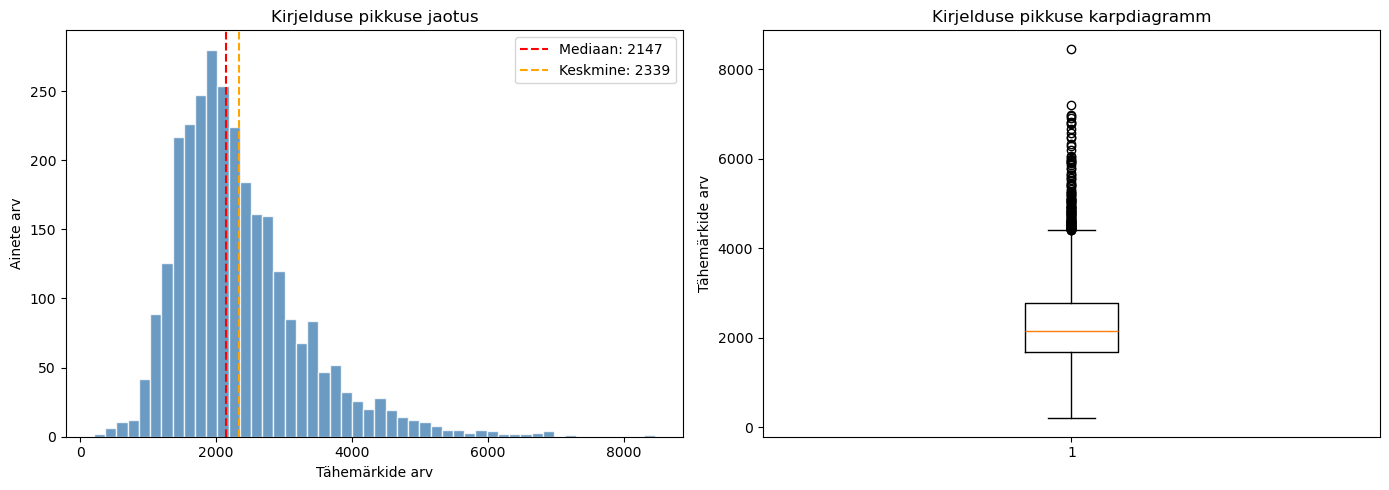


Lühim kirjeldus:  202 tähemärki
Pikim kirjeldus:  8462 tähemärki
Alla 200 tähemärgi: 0 ainet (0.0%)
Üle 2000 tähemärgi: 1680 ainet (57.9%)


In [12]:
# 7.4 Kirjelduse tähemärkide arvu statistika
import matplotlib
import matplotlib.pyplot as plt

kirjeldus_pikkused = df_final['kirjeldus'].str.len()

print("=" * 60)
print("KIRJELDUSE TÄHEMÄRKIDE ARVU STATISTIKA")
print("=" * 60)
print(kirjeldus_pikkused.describe().round(0))
print()

# Visualiseerimine
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogramm
axes[0].hist(kirjeldus_pikkused, bins=50, color='steelblue', edgecolor='white', alpha=0.8)
axes[0].set_xlabel('Tähemärkide arv')
axes[0].set_ylabel('Ainete arv')
axes[0].set_title('Kirjelduse pikkuse jaotus')
axes[0].axvline(kirjeldus_pikkused.median(), color='red', linestyle='--', label=f'Mediaan: {kirjeldus_pikkused.median():.0f}')
axes[0].axvline(kirjeldus_pikkused.mean(), color='orange', linestyle='--', label=f'Keskmine: {kirjeldus_pikkused.mean():.0f}')
axes[0].legend()

# Boxplot
axes[1].boxplot(kirjeldus_pikkused, vert=True)
axes[1].set_ylabel('Tähemärkide arv')
axes[1].set_title('Kirjelduse pikkuse karpdiagramm')

plt.tight_layout()
plt.show()

# Lühikesed ja pikad kirjeldused
print(f"\nLühim kirjeldus:  {kirjeldus_pikkused.min()} tähemärki")
print(f"Pikim kirjeldus:  {kirjeldus_pikkused.max()} tähemärki")
print(f"Alla 200 tähemärgi: {(kirjeldus_pikkused < 200).sum()} ainet ({(kirjeldus_pikkused < 200).sum() / len(df_final) * 100:.1f}%)")
print(f"Üle 2000 tähemärgi: {(kirjeldus_pikkused > 2000).sum()} ainet ({(kirjeldus_pikkused > 2000).sum() / len(df_final) * 100:.1f}%)")